<a href="https://colab.research.google.com/github/gitnicolas343/ejerciciosTAM-/blob/main/ejercicios13febrerovF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [ ]:
def add_gaussian_noise(images, mean=0, sigma=1):
    row, col = images.shape[1], images.shape[2]
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy_images = images + gauss
    return np.clip(noisy_images, 0, 255)

In [ ]:
def add_salt_pepper_noise(images, amount=0.05):
    noisy_images = np.copy(images)
    total_pixels = images.size
    num_salt = int(amount * total_pixels)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in images.shape]
    noisy_images[salt_coords[0], salt_coords[1]] = 255  # Salta

    num_pepper = int(amount * total_pixels)
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in images.shape]
    noisy_images[pepper_coords[0], pepper_coords[1]] = 0  # Pimienta
    return noisy_images

In [ ]:
# Preprocesar las imágenes (escalar y agregar ruido)
x_train_noisy_gaussian = add_gaussian_noise(x_train)
x_train_noisy_saltpepper = add_salt_pepper_noise(x_train)
x_test_noisy_gaussian = add_gaussian_noise(x_test)
x_test_noisy_saltpepper = add_salt_pepper_noise(x_test)

x_train = np.expand_dims(x_train, -1) / 255.0
x_train_noisy_gaussian = np.expand_dims(x_train_noisy_gaussian, -1) / 255.0
x_train_noisy_saltpepper = np.expand_dims(x_train_noisy_saltpepper, -1) / 255.0
x_test = np.expand_dims(x_test, -1) / 255.0
x_test_noisy_gaussian = np.expand_dims(x_test_noisy_gaussian, -1) / 255.0
x_test_noisy_saltpepper = np.expand_dims(x_test_noisy_saltpepper, -1) / 255.0

In [ ]:
gender_labels = {
    0: 1,  # T-shirt => Femenino
    1: 0,  # Trouser => Masculino
    2: 2,  # Pullover => Unisex
    3: 0,  # Dress => Masculino
    4: 1,  # Coat => Femenino
    5: 0,  # Sandal => Masculino
    6: 1,  # Shirt => Femenino
    7: 2,  # Sneaker => Unisex
    8: 0,  # Bag => Masculino
    9: 1,  # Ankle boot => Femenino
}

In [ ]:
y_train_gender = np.array([gender_labels[label] for label in y_train])
y_test_gender = np.array([gender_labels[label] for label in y_test])


In [ ]:
def build_autoencoder(inputs):
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(inputs, decoded)

autoencoder = build_autoencoder(inputs_1)
encoded_img = autoencoder(inputs_1)

# CNN para clasificar la prenda y el género
x = layers.Conv2D(32, (3, 3), activation='relu')(encoded_img)
x = layers.BatchNormalization()(x)  # Batch Normalization
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)  # Batch Normalization
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
class_output = layers.Dense(10, activation='softmax', name='class')(x)
gender_output = layers.Dense(3, activation='softmax', name='gender')(x)




In [ ]:
# Modelo final
model = models.Model(inputs=[inputs_1, inputs_2, inputs_3], outputs=[class_output, gender_output])

# Compilación del modelo
model.compile(optimizer='adam',
              loss={'class': 'sparse_categorical_crossentropy', 'gender': 'sparse_categorical_crossentropy'},
              metrics={'class': 'accuracy', 'gender': 'accuracy'})

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_11             │ (None, 28, 28, 1)      │         75,265 │ input_layer_9[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 26, 26, 32)     │            320 │ functional_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 26, 26, 32)     │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 13, 13, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 11, 11, 64)     │         18,496 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 11, 11, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 5, 5, 64)       │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 1600)           │              0 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │        204,928 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 10)             │          1,290 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 3)              │            387 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 301,070 (1.15 MB)

 Trainable params: 300,494 (1.15 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
# Entrenamiento del modelo
history = model.fit([x_train, x_train_noisy_gaussian, x_train_noisy_saltpepper],
                    {'class': y_train, 'gender': y_train_gender},
                    epochs=30,
                    batch_size=64,
                    validation_data=([x_test, x_test_noisy_gaussian, x_test_noisy_saltpepper], {'class': y_test, 'gender': y_test_gender}))

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - class_accuracy: 0.7856 - class_loss: 0.6133 - gender_accuracy: 0.8644 - gender_loss: 0.3458 - loss: 0.9591 - val_class_accuracy: 0.8797 - val_class_loss: 0.3366 - val_gender_accuracy: 0.9268 - val_gender_loss: 0.1955 - val_loss: 0.5312
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - class_accuracy: 0.8917 - class_loss: 0.2941 - gender_accuracy: 0.9353 - gender_loss: 0.1706 - loss: 0.4647 - val_class_accuracy: 0.8808 - val_class_loss: 0.3225 - val_gender_accuracy: 0.9326 - val_gender_loss: 0.1780 - val_loss: 0.4991
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - class_accuracy: 0.9044 - class_loss: 0.2597 - gender_accuracy: 0.9440 - gender_loss: 0.1494 - loss: 0.4091 - val_class_accuracy: 0.8702 - val_class_loss: 0.3470 - val_gender_accuracy: 0.9205 - val_gender_loss: 0.2117 - val_loss: 0.5588
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - class_accuracy: 0.9161 - class_loss: 0.2273 - gender_accuracy: 0.9524 - g

In [ ]:
# Evaluación y matrices de confusión
y_pred_class, y_pred_gender = model.predict([x_test, x_test_noisy_gaussian, x_test_noisy_saltpepper])
y_pred_class = np.argmax(y_pred_class, axis=1)
y_pred_gender = np.argmax(y_pred_gender, axis=1)

# Matrices de confusión y classification report
from sklearn.metrics import  classification_report

print("Classification Report - Class:")
print(classification_report(y_test, y_pred_class))

print("Classification Report - Gender:")
print(classification_report(y_test_gender, y_pred_gender))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Confusion Matrix - Class:
[[865   0  18  11   4   1  94   0   7   0]
 [  2 986   1   9   1   0   0   0   1   0]
 [ 13   1 913   8  22   0  43   0   0   0]
 [ 24   2  19 899  24   0  30   0   2   0]
 [  0   1 122  20 791   0  61   1   4   0]
 [  0   0   0   0   0 970   0  14   2  14]
 [106   2  80  17  55   0 734   0   6   0]
 [  0   0   0   0   0   9   1 971   0  19]
 [  6   0   3   6   1   2   0   1 980   1]
 [  0   0   0   0   0   2   1  32   0 965]]
Classification Report - Class:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.79      0.91      0.85      1000
           3       0.93      0.90      0.91      1000
           4       0.88      0.79      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.73      0.75      1000
           7       0.95      0.97     

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


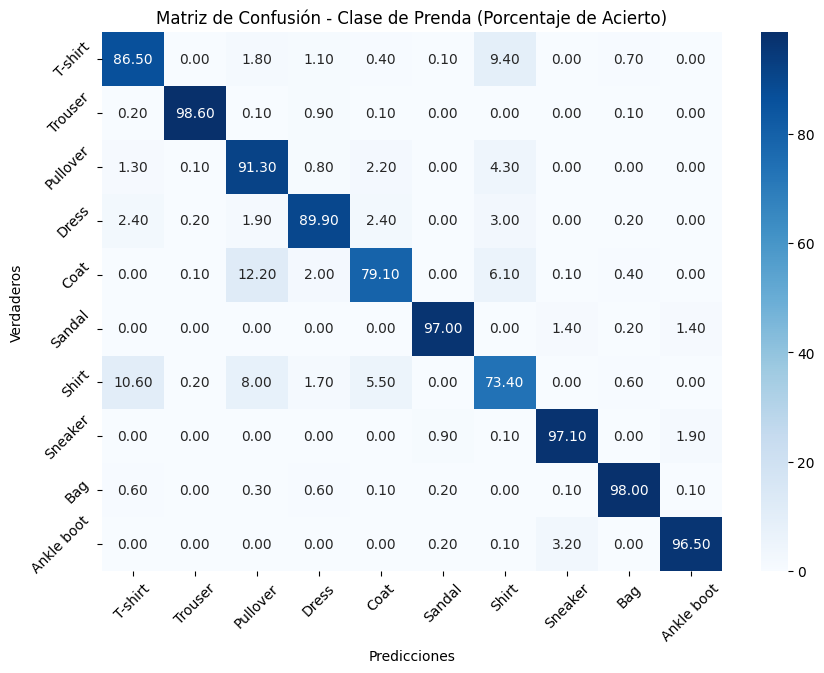

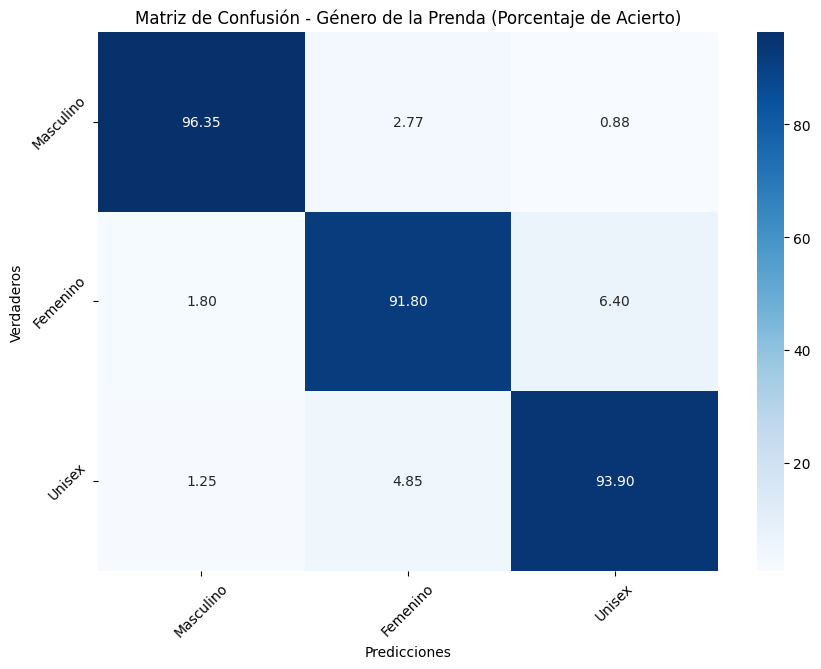

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


# Predicciones del modelo
y_pred_class = model.predict([x_test, x_test_noisy_gaussian, x_test_noisy_saltpepper])[0]
y_pred_gender = model.predict([x_test, x_test_noisy_gaussian, x_test_noisy_saltpepper])[1]

# Convertir las predicciones a clases (solo la categoría más probable)
y_pred_class = np.argmax(y_pred_class, axis=1)
y_pred_gender = np.argmax(y_pred_gender, axis=1)

# Etiquetas de clase de prendas y género
class_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
gender_labels = ['Masculino', 'Femenino', 'Unisex']

# Matriz de confusión para la clase de prenda
cm_class = confusion_matrix(y_test, y_pred_class)

# Convertir a porcentajes de acierto
cm_class_percentage = cm_class.astype('float') / cm_class.sum(axis=1)[:, np.newaxis] * 100

# Graficar la matriz de confusión para la clase de prenda con porcentajes
plt.figure(figsize=(10, 7))
sns.heatmap(cm_class_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión - Clase de Prenda (Porcentaje de Acierto)')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Matriz de confusión para el género
cm_gender = confusion_matrix(y_test_gender, y_pred_gender)

# Convertir a porcentajes de acierto
cm_gender_percentage = cm_gender.astype('float') / cm_gender.sum(axis=1)[:, np.newaxis] * 100

# Graficar la matriz de confusión para el género con porcentajes
plt.figure(figsize=(10, 7))
sns.heatmap(cm_gender_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=gender_labels, yticklabels=gender_labels)
plt.title('Matriz de Confusión - Género de la Prenda (Porcentaje de Acierto)')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Función para obtener las activaciones de las capas intermedias
def get_intermediate_activations(model, layer_names, input_data):
    # Crear un modelo que tenga como salida las activaciones de las capas de interés
    activation_model = models.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output for layer_name in layer_names])

    # Obtener las activaciones
    activations = activation_model.predict(input_data)
    return activations

# Función para reducir la dimensión y mostrar las representaciones
def visualize_activations(activations, labels, method='pca'):
    activations_flattened = []

    # Aplanar las activaciones para que puedan realizarse la reducción de dimensión
    for activation in activations:
        if len(activation.shape) > 2:
            # Aplanar si las activaciones tienen más de 2 dimensiones
            activation_flattened = activation.reshape((activation.shape[0], -1))
        else:
            activation_flattened = activation
        activations_flattened.append(activation_flattened)

    # Concatenar las activaciones de todas las capas (o mantenerlas separadas si es necesario)
    activations_flattened = np.concatenate(activations_flattened, axis=1)

    # Aplicar reducción de dimensión (PCA o t-SNE)
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced_activations = pca.fit_transform(activations_flattened)
    elif method == 'tsne':
        tsne = TSNE(n_components=2)
        reduced_activations = tsne.fit_transform(activations_flattened)

    # Visualizar las activaciones reducidas
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'Reduced Activations using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Obtener los nombres de las capas de tu modelo
layer_names = [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.MaxPooling2D) or isinstance(layer, layers.BatchNormalization)]

# Crear las tres entradas para el modelo
input_data = [x_test[:10], x_test_noisy_gaussian[:10], x_test_noisy_saltpepper[:10]]  # Seleccionar las tres i


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Activation shape for layer conv2d_22: (1000, 26, 26, 32)
Activation shape for layer batch_normalization_10: (1000, 26, 26, 32)
Activation shape for layer max_pooling2d_22: (1000, 13, 13, 32)
Activation shape for layer conv2d_23: (1000, 11, 11, 64)
Activation shape for layer batch_normalization_11: (1000, 11, 11, 64)
Activation shape for layer max_pooling2d_23: (1000, 5, 5, 64)
Activations retrieved successfully!


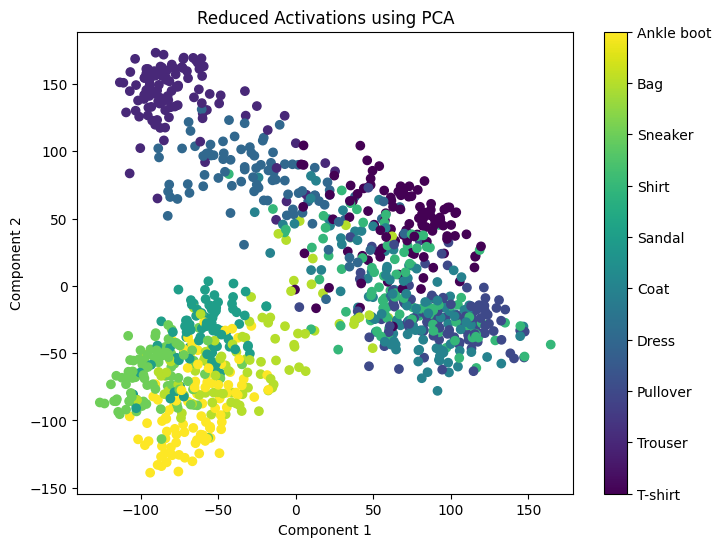

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Función para obtener las activaciones de las capas intermedias
def get_intermediate_activations(model, layer_names, input_data):
    # Crear un modelo que tenga como salida las activaciones de las capas de interés
    activation_model = models.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output for layer_name in layer_names])

    # Obtener las activaciones
    activations = activation_model.predict(input_data)

    # Imprimir las formas de las activaciones para asegurarnos de que estamos obteniendo las activaciones correctas
    for i, activation in enumerate(activations):
        print(f"Activation shape for layer {layer_names[i]}: {activation.shape}")

    return activations

# Función para reducir la dimensión y mostrar las representaciones
def visualize_activations(activations, labels, method='pca'):
    activations_flattened = []

    # Aplanar las activaciones para que puedan realizarse la reducción de dimensión
    for activation in activations:
        if len(activation.shape) > 2:
            # Aplanar si las activaciones tienen más de 2 dimensiones
            activation_flattened = activation.reshape((activation.shape[0], -1))
        else:
            activation_flattened = activation
        activations_flattened.append(activation_flattened)

    # Concatenar las activaciones de todas las capas (o mantenerlas separadas si es necesario)
    activations_flattened = np.concatenate(activations_flattened, axis=1)

    # Aplicar reducción de dimensión (PCA o t-SNE)
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced_activations = pca.fit_transform(activations_flattened)
    elif method == 'tsne':
        tsne = TSNE(n_components=2)
        reduced_activations = tsne.fit_transform(activations_flattened)

    # Crear una lista de nombres de clases (para etiquetas en la barra de color)
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Visualizar las activaciones reducidas
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], c=labels, cmap='viridis')

    # Añadir la barra de color con los nombres de las clases
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(np.arange(0, 10))
    cbar.set_ticklabels(class_names)  # Etiquetas de las clases en la barra

    plt.title(f'Reduced Activations using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Obtener los nombres de las capas de tu modelo
layer_names = [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.MaxPooling2D) or isinstance(layer, layers.BatchNormalization)]

# Crear las tres entradas para el modelo
input_data = [x_test[:1000], x_test_noisy_gaussian[:1000], x_test_noisy_saltpepper[:1000]]  # Seleccionar las tres imágenes para el conjunto de datos de prueba

# Obtener activaciones de las capas seleccionadas
activations = get_intermediate_activations(model, layer_names, input_data)

# Verificar que las activaciones se están obteniendo correctamente
print("Activations retrieved successfully!")

# Visualizar las activaciones con reducción de dimensión (PCA o t-SNE)
visualize_activations(activations, y_test[:1000], method='pca')  # Puedes cambiar a 'tsne' si prefieres t-SNE
